In [1]:
ROOT = './dataset'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= '0,1,2,3,4,5,6,7'#K80 #'1,2'#P40
import torch

import sys
sys.path.append('/mnt/mhjc/RS/ogblsc/ogb')

In [3]:
from ogb.lsc import PCQM4MDataset
dataset = PCQM4MDataset(only_smiles = True)

# get i-th molecule and its target value (nan for test data)
i = 1234
print(dataset[i]) # ('O=C1C=CC(O1)C(c1ccccc1C)O', 5.292614392225)

Using backend: pytorch


('O=C1C=CC(O1)C(c1ccccc1C)O', 5.292614392225)


In [4]:
split_dict = dataset.get_idx_split()
train_idx = split_dict['train'] # numpy array storing indices of training paper nodes
valid_idx = split_dict['valid'] # numpy array storing indices of validation paper nodes
test_idx = split_dict['test'] # numpy array storing indices of testing paper nodes

In [5]:
from ogb.utils import smiles2graph

# # if you use Pytorch Geometric (requires torch_geometric to be installed)
from ogb.lsc import PygPCQM4MDataset
pyg_dataset = PygPCQM4MDataset(root = ROOT, smiles2graph = smiles2graph) # pickle 을 사용해서 그런지, loading 시간이 훨씬 빠르다.

### Multi GPU

In [6]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class Regressor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Regressor, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.regress = nn.Linear(hidden_dim, 1)
        self.atom_encoder = AtomEncoder(emb_dim = in_dim).to(torch.device('cuda'))

    def forward(self, data):
#         print('Inside Model:  num graphs: {}, device: {}'.format(
#             data.num_graphs, data.batch.device))
        h, edge_index, batch = data.x, data.edge_index, data.batch
        
        # 1. Obtain node embeddings 
        # Apply graph convolution and activation.
        h = self.atom_encoder (h)
        h = self.conv1(h, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        
        # 2. Readout layer
        h = global_mean_pool(h, batch) # [batch_size, hidden_channels]
        
        # 3. Apply a final classifier
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.regress(h)
        
        
        return h

In [48]:
import torch.nn.functional as F
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

def train(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    model.train()
    
    count = 0
    for data_list in train_loader:  # Iterate in batches over the training dataset.
        out = model(data_list)  # Perform a single forward pass.
        loss = criterion(out, torch.cat( [data.y for data in data_list] , dim = 0).reshape([-1,1]).to(torch.device('cuda')) )  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        
        if count % 2 == 0:
            batch_loss = loss
            print(f'Iter: {count:03d}, Train batch_loss: {batch_loss:.4f}')
        count += 1
        
def test(model, loader):
    model.eval()

    tot_loss = 0
    tot_count = 0
    for data_list in loader:  # Iterate in batches over the training/test dataset.
        out = model(data_list)
        loss = F.mse_loss(out, torch.cat( [data.y for data in data_list] , dim = 0).reshape([-1,1]).to(torch.device('cuda')) )
        tot_loss += loss*len(data_list)
        tot_count += len(data_list)
        
    return tot_loss / tot_count # Derive mean squared error of regressions.

In [41]:
from torch_geometric.data import DataListLoader
torch.manual_seed(12345)

train_loader = DataListLoader(pyg_dataset[[int(i) for i in train_idx]], batch_size=1024*8*8, shuffle=True)
valid_loader = DataListLoader(pyg_dataset[[int(i) for i in valid_idx]], batch_size=1024*8*8, shuffle=False)
test_loader = DataListLoader(pyg_dataset[[int(i) for i in test_idx]], batch_size=1024*8*8, shuffle=False)

In [ ]:
# decay = 1-np.exp(-np.log(2)/26) # half-life = 26 iter (1024*8*8 ea. / batch)

In [17]:
from torch_geometric.nn import DataParallel

model = Regressor(in_dim = 100, hidden_dim =64)
print('Let\'s use', torch.cuda.device_count(), 'GPUs!')
model = DataParallel(model).to(torch.device('cuda'))
for epoch in range(1, 5):
    train(model, train_loader)
    train_loss = test(model, train_loader)
    valid_loss = test(model, valid_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}')
                      

Let's use 8 GPUs!
Iter: 000, Train batch_loss: 32.7525
Iter: 002, Train batch_loss: 30.9609
Iter: 004, Train batch_loss: 29.0600
Iter: 006, Train batch_loss: 26.7507
Iter: 008, Train batch_loss: 24.2385
Iter: 010, Train batch_loss: 21.5491
Iter: 012, Train batch_loss: 18.8230
Iter: 014, Train batch_loss: 15.6910
Iter: 016, Train batch_loss: 12.5644
Iter: 018, Train batch_loss: 9.6110
Iter: 020, Train batch_loss: 6.7818
Iter: 022, Train batch_loss: 4.5248
Iter: 024, Train batch_loss: 3.2178
Iter: 026, Train batch_loss: 2.9067
Iter: 028, Train batch_loss: 3.5543
Iter: 030, Train batch_loss: 4.3833
Iter: 032, Train batch_loss: 4.4758
Iter: 034, Train batch_loss: 4.0078
Iter: 036, Train batch_loss: 3.3128
Iter: 038, Train batch_loss: 2.8168
Iter: 040, Train batch_loss: 2.6287
Iter: 042, Train batch_loss: 2.6176
Iter: 044, Train batch_loss: 2.7124
Iter: 046, Train batch_loss: 2.7575
Epoch: 001, Train loss: 1.4546, Test loss: nan
Iter: 000, Train batch_loss: 2.8104
Iter: 002, Train batch_los

In [65]:
data_df.head()

,idx,smiles,homolumogap
0,0,Cc1ccc(cc1)C1C=c2cnccc2=NC1=O,3.047675
1,1,COc1cc(OC)ccc1C=CN(C(=O)C)C,4.410966
2,2,C=CCN(C(=O)C)C=Cc1ccccc1C,4.639541
3,3,C=CCN(C(=O)C)C=Cc1ccccc1F,4.492600
4,4,C=CCN(C(=O)C)C=Cc1ccccc1Cl,4.612330


In [64]:
import pandas as pd
import os.path as osp
data_df = pd.read_csv(osp.join('dataset/pcqm4m_kddcup2021/raw', 'data.csv.gz'))

In [80]:
valid_out = model( pyg_dataset[list(valid_idx)] )

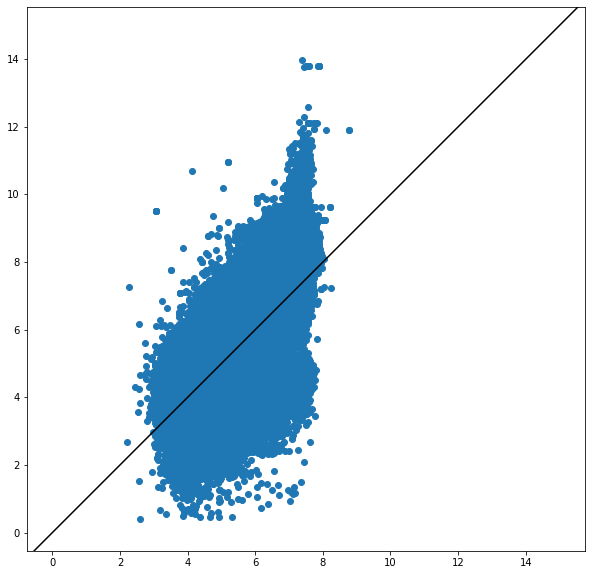

In [101]:
from matplotlib import pyplot as plt
plt.figure(figsize = [10,10])
plt.scatter(list(valid_out.cpu().detach().numpy()), list(data_df.iloc[valid_idx, 2]))
plt.xlim((0,9))
plt.axis('equal')
plt.axline([0,0],[15,15], c = 'black')
plt.show()

In [75]:
from torch_geometric.data import Data

= list()
for idx in train_idx:
    data = Data()
    smiles = dataset[idx][0]
    homolumogap = dataset[idx][1]
    graph = smiles2graph(smiles)

    assert(len(graph['edge_feat']) == graph['edge_index'].shape[1])
    assert(len(graph['node_feat']) == graph['num_nodes'])

    data.__num_nodes__ = int(graph['num_nodes'])
    data.edge_index = torch.from_numpy(graph['edge_index']).to(torch.int64)
    data.edge_attr = torch.from_numpy(graph['edge_feat']).to(torch.int64)
    data.x = torch.from_numpy(graph['node_feat']).to(torch.int64)
    data.y = torch.Tensor([homolumogap])

    model.eval()
    out = model([data])

TypeError: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Series

In [63]:
smiles

'COc1ccccc1N[C@@H](C(=NC(=N)O)O)C'

In [62]:
out # HOMO-LUMO prediction

tensor([[4.8430]], device='cuda:0', grad_fn=<GatherBackward>)

In [71]:
F.mse_loss(out.reshape([-1,]), data.y.to(torch.device('cuda')) )

tensor(1.2605, device='cuda:0', grad_fn=<MseLossBackward>)

### Single GPU

In [7]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class Regressor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Regressor, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.regress = nn.Linear(hidden_dim, 1)

    def forward(self, h, edge_index, batch):
        # 1. Obtain node embeddings 
        # Apply graph convolution and activation.
        atom_encoder = AtomEncoder(emb_dim = 100).to(torch.device('cuda'))
        h = atom_encoder(h)
        h = self.conv1(h, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        
        # 2. Readout layer
        h = global_mean_pool(h, batch) # [batch_size, hidden_channels]
        
        # 3. Apply a final classifier
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.regress(h)
        
        return h

In [11]:
import torch.nn.functional as F
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

def train(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(torch.device('cuda'))
        out = model(data.x, 
                    data.edge_index, 
                    data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.reshape([-1,1]) )  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(model, loader):
    model.eval()

    loss = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(torch.device('cuda'))
        out = model(data.x, 
                    data.edge_index, 
                    data.batch)
        loss += F.mse_loss(out, data.y.reshape([-1,1]) )
    return loss # Derive mean squared error of regressions.

In [8]:
from torch_geometric.data import DataLoader
torch.manual_seed(12345)

train_loader = DataLoader(pyg_dataset[[int(i) for i in train_idx]], batch_size=64, shuffle=True)
test_loader = DataLoader(pyg_dataset[[int(i) for i in test_idx]], batch_size=64, shuffle=False)

In [ ]:
model = Regressor(in_dim = 100, hidden_dim =64).to(torch.device('cuda'))
for epoch in range(1, 201):
    train(model, train_loader)
    train_loss = test(model, train_loader)
    test_loss = test(model, test_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')
                      

/mnt/mhjc/miniconda3/envs/ogblsc/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/mnt/mhjc/miniconda3/envs/ogblsc/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/mnt/mhjc/miniconda3/envs/ogblsc/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please

In [45]:
# del model
# del dataloader
# torch.cuda.empty_cache()
import gc
gc.collect()

0

In [61]:
print(dgl_dataset[0])

(Graph(num_nodes=18, num_edges=40,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}), tensor(3.0477))
